ENSAE 3A 2019-2020

Hugo Thimonier, Gabriel Kasmi

# Compressed sensing
## Generative models for compressed sensing and their extensions

This notebook reproduces some of the key results derived by Bora et. al. 2017 and Dhar et. al. 2018. 

Our replications are conducted on the MNIST dataset using a LASSO reconstruction technique (aka sparse recovery) in section 1 and a custom-made generative method based on the paper and our home-made GAN trained on the MNIST dataset. For more information regarding the training of the generative model, see the notebook ```train_mnist_gan```.

## 0. Load and import the dataset

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
import cvxpy as cvx

In [3]:
from keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()


Using TensorFlow backend.
/Users/Gabriel/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Gabriel/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Gabriel/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Gabriel/anaconda3/lib/python3.6/site-packag

In [4]:
# We wont reconstruct all images but only a subset of n_img of it
n_img = 10
images = trainX[:n_img]

## 1. Reconstruction using LASSO (sparse recovery)

In this first section, we reconstruct using the LASSO with 50, 100 and 500 measurements. As it can be seen below, the reconstruction peforms poorly with few measurements but is better when the number of measurements increase. 

In [122]:
import math

# set the dimension of the signal space (28*28 (* 1))
n = 784

# Define the basis pursuit algorithm for sparse recovery
def basis_pursuit(n, A, y):
    """
    this function implements the basis pursuit algorithm given a
    measurement matrix, a dimension n of the signal space and
    a measurement y (with dimension m << n)
    
    arguments:
    - ``n`` integer corresponding to the dimension of the signal 
    space
    - ``A`` a m*n measurement matrix
    - ``y`` a signal of dimension m*1
    """
    P, q = np.array(A), np.array(y).astype(np.double).flatten()
    # control variable
    x = cvx.Variable(n)
    # objective function
    obj = cvx.Minimize(cvx.norm(x,1))
    # constraint
    const = [P * x == q]
    # definition of the optimisation problem
    prob = cvx.Problem(obj,const)
    result = prob.solve()

    return x.value

def generate_lasso(m, n, x_star):
    """
    this function generates a noisy observation from a signal x_star 
    and performs the reconstruction using the BP algorithm 
    
    arguments:
    - `m` the number of measurements
    - `n` the dimension of the signal space
    -`x_star` the signal we wish to reconstruct
    
    Returns the value of "x_hat" i.e. the reconstruction of
    x_star using LASSO.
    """
    
    # generate a gaussian measurement matrix
    # mean = 0 and variance 1 / m (as in the article)
    A = np.random.normal(0,1/math.sqrt(m),(m,n)).squeeze()
    
    # gaussian noise
    noise = np.random.normal(0,1,(m,))

    # generate the measurement
    y = np.dot(A,x_star) + noise
    
    return basis_pursuit(n, A, y)


In [134]:
# three lists of reconstructed signals with 50, 100 and 500 measurements.

outputs_lasso_25 = [generate_lasso(50, n, np.reshape(x_star,-1)) for x_star in images]
outputs_lasso_100 = [generate_lasso(100, n, np.reshape(x_star,-1)) for x_star in images]
outputs_lasso_500 = [generate_lasso(500, n, np.reshape(x_star,-1)) for x_star in images]

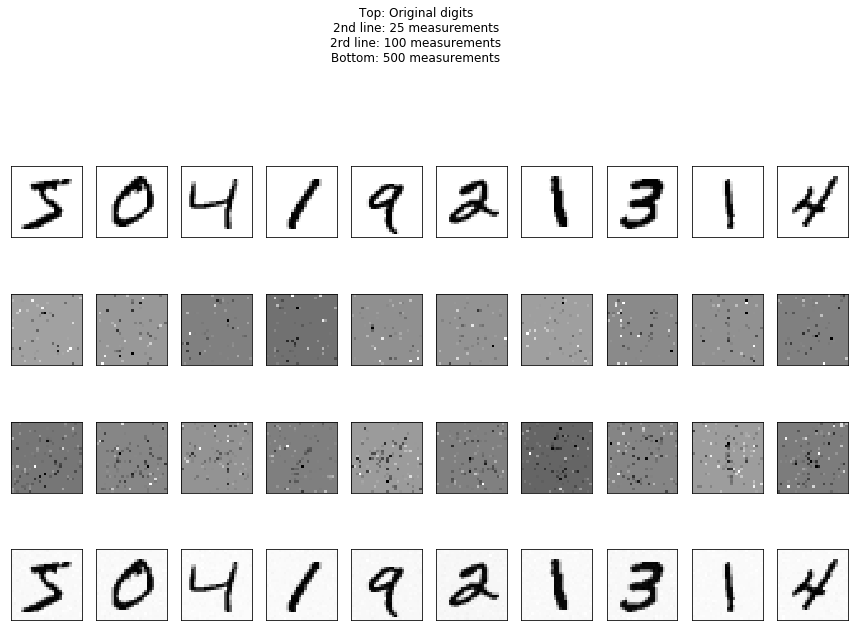

In [135]:
# Plots
fig, ax = plt.subplots(4, n_img, figsize=(15,9))
for j in range(n_img):
    ax[0,j].imshow(images[j], cmap ='gray_r')
    ax[1,j].imshow(outputs_lasso_25[j].reshape(28,28), cmap ='gray_r')
    ax[2,j].imshow(outputs_lasso_100[j].reshape(28,28), cmap ='gray_r')
    ax[3,j].imshow(outputs_lasso_500[j].reshape(28,28), cmap ='gray_r')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])    
    ax[3,j].set_xticks([])
    ax[3,j].set_yticks([])    
fig.suptitle('''Top: Original digits
2nd line: 25 measurements
2rd line: 100 measurements
Bottom: 500 measurements''', y = 1.1)
plt.show()

In [143]:
def measurement_error(x_hat, x_star):
    """
    computes the l2 norm between the reconstruction
    and the source signal
    
    arguments: 
    - `x_hat`: the reconstructed signal
    -`x_star` : the source image. Should be in 2d 28*28 format)
    
    returns the l2 error between x_hat and x_star
    """
    
    return np.linalg.norm(x_hat - np.reshape(x_star, -1))

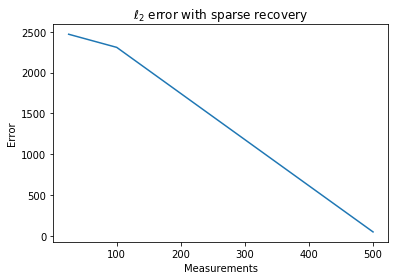

In [157]:
# compute and plot the measurement error for the three reconstructions 

measurement = [25, 100 , 500]
outputs = [outputs_lasso_25, outputs_lasso_100, outputs_lasso_500]

errors = []
for item in outputs:
    errors.append(np.mean([measurement_error(item[j], images[j]) for j in range(n_img)]))

plt.plot(measurement, errors)
plt.xlabel("Measurements")
plt.ylabel("Error")
plt.title("$\ell_2$ error with sparse recovery")
plt.show()

The shape of the decaying loss function matches that of Bora et al (fig. 1. (a))

## 2. Reconstruction using generative models

Let us now reconstruct the same images but using the generative method of Bora et. al. (2017).

In [5]:
import keras
# Import the model
gan_mnist = keras.models.load_model('generator_model_100.h5')

/Users/Gabriel/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Définition des fonctions permettant de reconstruire le signal 

In [6]:
from keras import backend as K
import tensorflow as tf
from keras.optimizers import Adam

def generate_measured_signal(m, n, X_star):
    """
    this function takes an image and turns it into a noisy signal. 
    
    Arguments
    - m the number of measurements
    - n the dimension of the signal space
    - X_star the signal to reconstruct
    - regularization a boolean on whether or not to include 
    a regularization in the loss function
    """
    # Define the measurement matrix
    A_ = K.random_normal_variable(shape=(m, n), mean=0, scale=1/math.sqrt(m))
    
    # Initialize the tf session 
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())    

    # Define the observation noise
    neta = np.random.normal(loc=0.0, scale=.1/math.sqrt(m), size=(m,))
    # Convert the measurement matrix to a numpy array and reshape the input vector
    A_np = A_.eval()
    x_flatten = np.reshape(X_star,-1)

    # Compute the noisy signal 
    y = np.dot(A_np,x_flatten) + neta 
    sess.close()
    
    return y, A_

def custom_loss(generator, x, y, A_, lambda__ = 0.1, regularization = True):
    
    '''
    function that return the loss used in the paper
    
    Arguments :
    - generator : the generator considered
    - x : the input vector for the generator
    - y : the true y
    - lambda__: regularization term
    - regularization : boolean for regularization
    
    '''
    if regularization: 
        loss = np.linalg.norm(np.dot(A_.eval(),
                                     np.reshape(generator.predict(x)[0,:,:,0], -1)) - y) + lambda__*np.linalg.norm(x)
    else :
        loss = np.linalg.norm(np.dot(A_.eval(),
                                     np.reshape(generator.predict(x)[0,:,:,0], -1)) - y)  
    return loss

def sens(generator, A_, y , lambda_ = 0.1, m = 50, n = 784, eta = 0.01, n_steps = 100, regularization = True):
    """
    gradient descent to get the latent vector 
    
    Arguments :
    - generator : the generator considered
    - A_ : gaussian matrix considered
    - y : the signal 
    - lambda_: regularization term
    - m : the number of measurements
    - n : the dimension of the signal space
    - eta : learning rate
    - n_steps : number of iteration in the gradient descent
    - regularization : boolean for regularization
    
    Output : 
    predicted latent vector for signal y
    """
    
    target = K.constant(y)    
    if regularization :
    # on calcule la loss
        loss = K.square(tf.norm(K.dot(A_, K.reshape(gan_mnist.output,shape=(784, 1))) - target, ord='euclidean')) + lambda_*tf.norm(generator.input, ord='euclidean') 
    else :
        loss = K.square(tf.norm(K.dot(A_, K.reshape(gan_mnist.output,shape=(784, 1))) - target, ord='euclidean')) + 0*tf.norm(generator.input, ord='euclidean')
        
    gradients = K.gradients(loss, generator.input)
    z_best = np.asarray([[np.random.uniform(100) for _ in range(100)]])
    
    # sample 10 vector in the latent space
    for _ in range(10):
        z = np.asarray([[np.random.uniform(100) for _ in range(100)]])
    
        for __ in range(n_steps):
        
            sess = tf.InteractiveSession()
            sess.run(tf.global_variables_initializer())
            evaluated_gradient = sess.run(gradients,feed_dict={generator.input:z})
            z -= eta * evaluated_gradient[0][0]
            
        if regularization :
            if custom_loss(generator, z, y, A_, lambda__ = lambda_) < custom_loss(generator, z_best, y, A_, lambda__ = lambda_):
                z_best = z
        else : 
            if custom_loss(generator, z, y, A_, lambda__ = 0) < custom_loss(generator, z_best, y, A_, lambda__ = 0):
                z_best = z
    sess.close()
    return z_best

In [7]:
def generate_gan(m, n, X_star, generator, n_steps = 100):
    """
    todo
    """
    y, A_ = generate_measured_signal(m, n, X_star)
    z_opt = sens(generator, A_, y, n_steps = n_steps, regularization = True, m = m, n = n)
    
    return generator.predict(z_opt)

In [ ]:
import warnings
warnings.simplefilter('ignore')
n = 28*28

outputs_lasso_25 = [generate_gan(50, n, x_star, gan_mnist, n_steps = 100) for x_star in images]
#outputs_lasso_100 = [generate_gan(100, n, x_star, gan_mnist, n_steps = 1) for x_star in images]
#outputs_lasso_500 = [generate_gan(500, n, x_star, gan_mnist, n_steps = 1) for x_star in images]

In [ ]:
# Plots
fig, ax = plt.subplots(4, n_img, figsize=(15,9))
for j in range(n_img):
    ax[0,j].imshow(images[j], cmap ='gray_r')
    ax[1,j].imshow(outputs_lasso_25[j][0,:,:,0], cmap ='gray_r')
#    ax[2,j].imshow(outputs_lasso_100[j][0,:,:,0], cmap ='gray_r')
#    ax[3,j].imshow(outputs_lasso_500[j][0,:,:,0], cmap ='gray_r')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
#    ax[2,j].set_xticks([])
#    ax[2,j].set_yticks([])    
#    ax[3,j].set_xticks([])
#    ax[3,j].set_yticks([])    
fig.suptitle('''Top: Original digits
2nd line: 25 measurements
2rd line: 100 measurements
Bottom: 500 measurements''', y = 1.1)
plt.show()